**1.项目概述**

随着我国市场经济的发展，企业竞争日益加剧，因此，企业需要精准营销更有针对性、更高效捕捉目标客户、降低企业运营成本，从而提升客户满意度，增加营销活动投资回报率，促进企业效益的增加。


**本案例基于银行产品营销数据进行数据分析，根据客户的背景信息及历史营销服务交互信息，去预测客户对新产品的接受概率，筛选可能购买产品的客户群，提高营销效率。(人话：挖掘潜在客户)**


项目分析方法：决策树、可视化图表

**2.实现过程**  


第一步，数据读取和导入，并进行数据预处理。输入数据保存在bank.csv文件中，包括一万多条记录，17个属性变量。由于数据量大，变量多，数据信息的查阅、缺失值处理、异常值检测等预处理非常重要。

### 实现：

**1.数据读取、缺失值分析、统计分析。** 


**【关键技术】**  


列出数据的统计信息（如均值、标准差等）describe、绘制直方图hist、箱图seaborn.boxplot、seaborn.distplot、计数value_counts、删除某一行或列drop、替换replace、哑变量get_dummies。  

哑变量：也叫虚拟变量，引入哑变量的目的是，将不能够定量处理的变量量化。

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
get_ipython().run_line_magic('matplotlib', 'inline')

from sklearn.metrics import roc_curve, auc

# 设置字体为黑体大小为11
plt.rc('font', family='SimHei', size=11)
matplotlib.rcParams['axes.unicode_minus'] = False

# 取消显示未来警告问题
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")
pd.set_option('future.no_silent_downcasting', True)

In [2]:
bank = pd.read_csv('bank.csv')
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,18,student,single,unknown,no,108,no,no,cellular,10,aug,167,1,-1,0,unknown,yes
1,18,student,single,primary,no,608,no,no,cellular,12,aug,267,1,-1,0,unknown,yes
2,18,student,single,unknown,no,108,no,no,cellular,8,sep,169,1,-1,0,unknown,yes
3,18,student,single,primary,no,608,no,no,cellular,13,nov,210,1,93,1,success,yes
4,18,student,single,unknown,no,108,no,no,cellular,9,feb,92,1,183,1,success,yes


In [3]:
# 统计每列的缺失值
bank.isna().astype(int).sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [4]:
# 查看数值类型变量的描述统计
bank.describe().T

,count,mean,std,min,25%,50%,75%,max
age,11162.0,41.231948,11.913369,18.0,32.0,39.0,49.00,95.0
balance,11162.0,1528.538524,3225.413326,-6847.0,122.0,550.0,1708.00,81204.0
day,11162.0,15.658036,8.420740,1.0,8.0,15.0,22.00,31.0
duration,11162.0,371.993818,347.128386,2.0,138.0,255.0,496.00,3881.0
campaign,11162.0,2.508421,2.722077,1.0,1.0,2.0,3.00,63.0
pdays,11162.0,51.330407,108.758282,-1.0,-1.0,-1.0,20.75,854.0
previous,11162.0,0.832557,2.292007,0.0,0.0,0.0,1.00,58.0


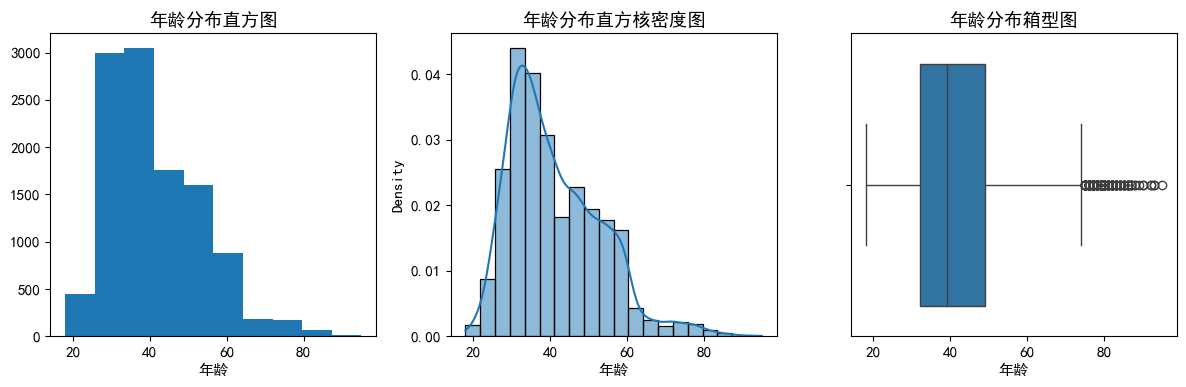

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 布局定要合理不然会多输出很多图例
axes[0].hist(bank.age, bins=10)
axes[0].set_title('年龄分布直方图')
axes[0].set_xlabel('年龄')

# 核密度分布曲线图，每个 bin 的面积占比总面为1
# stat='density' 表示概率密度
sns.histplot(bank.age, bins=20, ax=axes[1], kde=True, stat='density')  # kde=True：启用 KDE（核密度估计）曲线
axes[1].set_title('年龄分布直方核密度图')
axes[1].set_xlabel('年龄')

sns.boxplot(x=bank['age'], ax=axes[2])
axes[2].set_title('年龄分布箱型图')
axes[2].set_xlabel('年龄')

plt.tight_layout()  # 优化子图之间的间距，避免重叠
plt.show()

In [6]:
# 字符型变量的频数分布
bank_data = bank.copy()
print(bank_data.job.value_counts())
print('\n')
print(bank_data.education.value_counts())

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64


education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64


**2.数据处理、筛选、特征提取等。**  


包括变量格式转换、样本合并、删除变量、特殊变量衍生、哑变量处理。  


将变量default、housing、loan、deposit转换为0-1变量，即数值型变量，才能进行模型训练。  


同时，将job、poutcome变量中的相似样本进行合并，如job变量值为‘management'‘admin’的合并为‘white-collar’。将不需要的变量直接删除。

**变量Pdays是以前活动中客户最后一次被联系到现在的天数，取值为-1即从没有联系过，需要把-1转换为足够大的数值，表示客户从没有被联系过。**  


最后，变量job、marital、education、contact、poutcome是字符型变量，需要进行哑变量处理。  

**哑变量，又称虚拟变量，通常取值为0或1，即one-hot编码，反映某个变量的不同属性。**

In [7]:
# 将字符串类型'yes', 'no'转化为 0-1 数值
# 将相似的 job 归类
# 将营销结果 poutcome 列的 other 转化为 unknown
# default, housing, loan, deposit 转化为0-1并删除原始变量

columns_0_1 = ['default', 'housing', 'loan', 'deposit', 'job']

# 元组无法映射只能是每个值作为单独的键才可以映射
mapping = {
    'yes': 1,
    'no': 0,
    'management': 'white-collar',
    'admin.': 'white-collar',
    'housemaid': 'pink-collar',
    'services': 'pink-collar',
    'retired': 'other',
    'student': 'other',
    'unemployed': 'other',
    'unknown': 'other',
}

# 法一  replace
# for column in columns_0_1:
    # bank[column] = bank[column].replace(mapping)
    
# 法二  map
for column in columns_0_1:
    bank_data[column] = bank_data[column].map(lambda x: mapping.get(x, x))

# 将 营销结果 poutcome 列的 other 转化为 unknown
bank_data['poutcome'] = bank_data['poutcome'].replace(['other'], 'unknown')

# 删除不需要的时间序列变量
bank_data.drop('month', axis=1, inplace=True)
bank_data.drop('day', axis=1, inplace=True)

# 特殊变量衍生，哑变量处理
# pdays变量表示多久没有联系, -1表示很久没联系
print('pdays取值为-1的样本数:', (bank_data['pdays'] == -1).sum())  # .count是计算非空个数,sum才是统计True的个数
print('pdays的最大值:', bank_data['pdays'].max())  # 找最大值是为了确定失去联系的最长天数-1替换时要大于最大值

# 将值为 -1 转换为足够大的值表示很久没联系
# 按行操作
# bank_data.loc[bank_data['pdays'] == -1, 'pdays'] = 10000  
# 直接在列上修改
bank_data['pdays'] = bank_data['pdays'].replace(-1, 1000)  # 表示1w天没联系

# 哑变量
bank_with_dummies = pd.get_dummies(data=bank_data, 
                                   columns=['job', 'marital',
                                            'education', 'contact', 'poutcome'],
                                   prefix=['job', 'marital',
                                           'education', 'contact', 'poutcome'])

bank_data.head()

pdays取值为-1的样本数: 8324
pdays的最大值: 854


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,deposit
0,18,other,single,unknown,0,108,0,0,cellular,167,1,1000,0,unknown,1
1,18,other,single,primary,0,608,0,0,cellular,267,1,1000,0,unknown,1
2,18,other,single,unknown,0,108,0,0,cellular,169,1,1000,0,unknown,1
3,18,other,single,primary,0,608,0,0,cellular,210,1,93,1,success,1
4,18,other,single,unknown,0,108,0,0,cellular,92,1,183,1,success,1


In [8]:
bank_with_dummies = bank_with_dummies.astype(int)
bank_with_dummies.head()

,age,default,balance,housing,loan,duration,campaign,pdays,previous,deposit,...,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_success,poutcome_unknown
0,18,0,108,0,0,167,1,1000,0,1,...,0,0,0,1,1,0,0,0,0,1
1,18,0,608,0,0,267,1,1000,0,1,...,1,0,0,0,1,0,0,0,0,1
2,18,0,108,0,0,169,1,1000,0,1,...,0,0,0,1,1,0,0,0,0,1
3,18,0,608,0,0,210,1,93,1,1,...,1,0,0,0,1,0,0,0,1,0
4,18,0,108,0,0,92,1,183,1,1,...,0,0,0,1,1,0,0,0,1,0


**3.相关性分析。计算相关系数，绘制相关系数矩阵、热力图。**  


**【关键技术】**  
计算相关系数corr( )  
定制调色板seaborn.diverging_palette( )  
绘制热力图seaborn.heatmlap( )  

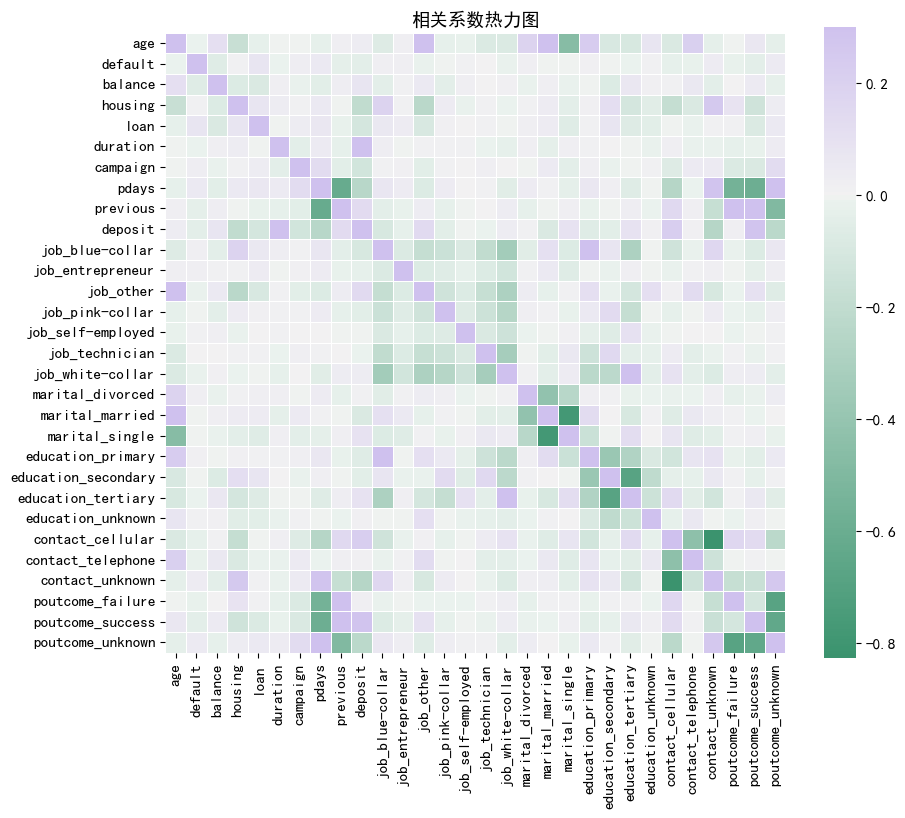

In [19]:
# 相关性分析
# 相关系数
corr = bank_with_dummies.corr()

plt.figure(figsize=(10, 10))
# 定制离散调色板
cmap = sns.diverging_palette(150, 275, s=80, l=55, n=9, as_cmap=True)
# 热图
sns.heatmap(corr, xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap=cmap, vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={'shrink': .82})
plt.title('相关系数热力图')
plt.show()

**4.创建决策树模型，并训练测试模型，计算模型精度。**

**【关键技术】**  


数据集分割train_test_split(、创建决策树模型DecisionTreeClassifier( )、训练模型fit( )、测试模型predict( )、predict_proba( )、模型评估score( )、roc_auc_score( )。其中，predict( )返回的是一个预测值，predict_proba( )返回的是对于预测为各个类别的概率。  


**由于不明确决策树的最大深度应该设为多少，因此，对决策树深度进行循环，计算每个参数的模型准确率，确定最大深度。**

深度: 1
训练精度: 72.34%
测试精度: 70.23%
深度: 2
训练精度: 77.06%
测试精度: 75.25%
深度: 3
训练精度: 78.11%
测试精度: 76.65%
深度: 4
训练精度: 78.37%
测试精度: 76.44%
深度: 5
训练精度: 79.64%
测试精度: 78.05%
深度: 6
训练精度: 81.58%
测试精度: 78.83%
深度: 7
训练精度: 82.72%
测试精度: 78.59%
深度: 8
训练精度: 83.9%
测试精度: 79.28%
深度: 9
训练精度: 84.99%
测试精度: 78.89%


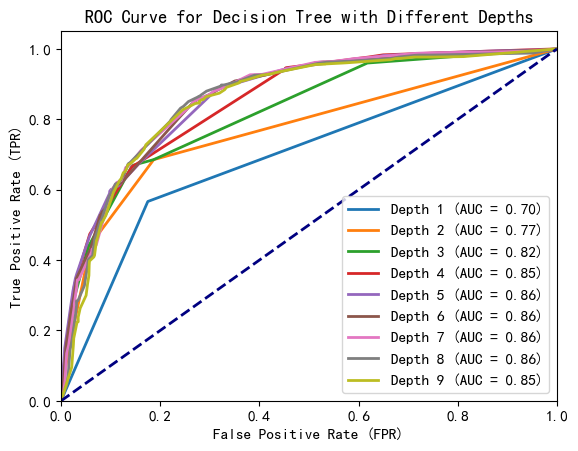

深度 1 的 AUC: 0.69570
深度 2 的 AUC: 0.77118
深度 3 的 AUC: 0.82203
深度 4 的 AUC: 0.85227
深度 5 的 AUC: 0.86219
深度 6 的 AUC: 0.86167
深度 7 的 AUC: 0.86265
深度 8 的 AUC: 0.85904
深度 9 的 AUC: 0.85273


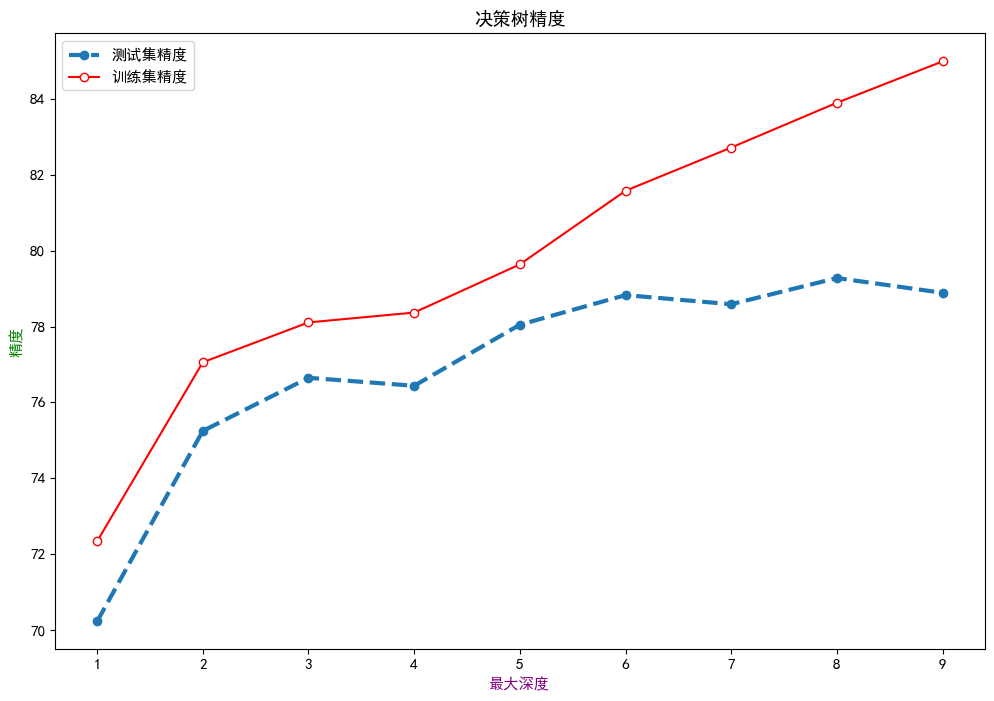

In [10]:
# 数据集准备
bank_with_dummies_drop_deposite = bank_with_dummies.drop('deposit', axis=1)  # 输入集
label = bank_with_dummies.deposit  # 输出集

# 数据集拆分
data_train, data_test, label_train, label_test = train_test_split(
    bank_with_dummies_drop_deposite, label, test_size=0.3, random_state=50
)

# 初始化列表存储精度和 AUC
k_plot = []  # 存储测试集精度
t_plot = []  # 存储训练集精度
auc_values = []  # 存储每个深度的 AUC 值

# 遍历不同深度的决策树
for k in range(1, 10):
    # 创建决策树模型
    dt = DecisionTreeClassifier(max_depth=k, random_state=101)
    dt.fit(data_train, label_train)  # 训练模型

    # 计算精度
    accuracy_test = round(dt.score(data_test, label_test) * 100, 2)
    accuracy_train = round(dt.score(data_train, label_train) * 100, 2)

    # 打印结果
    print(f"深度: {k}")
    print(f"训练精度: {accuracy_train}%")
    print(f"测试精度: {accuracy_test}%")

    # 存储精度
    k_plot.append(accuracy_test)
    t_plot.append(accuracy_train)

    # 计算 ROC 曲线和 AUC
    y_prob = dt.predict_proba(data_test)[:, 1]  # 获取正类概率
    fpr, tpr, _ = roc_curve(label_test, y_prob)  # ROC 曲线
    roc_auc = auc(fpr, tpr)  # AUC 计算
    auc_values.append(roc_auc)  # 存储 AUC

    # 绘制每个深度的 ROC 曲线
    plt.plot(fpr, tpr, lw=2, label=f'Depth {k} (AUC = {roc_auc:.2f})')

# 绘制随机猜测的参考线
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# ROC 曲线图表设置
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Decision Tree with Different Depths')
plt.legend(loc='lower right')
plt.show()

# 打印 AUC 结果
for i, auc_value in enumerate(auc_values, 1):
    print(f"深度 {i} 的 AUC: {auc_value:.5f}")

# 绘制精度折线图
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
axes.set_xticks(range(1, 10))
plt.title('决策树精度')
plt.xlabel('最大深度', c='purple')
plt.ylabel('精度', c='g')

# 绘制测试集和训练集精度曲线
plt.plot(range(1, 10), k_plot, linewidth=3.0, linestyle='--', marker='o', label='测试集精度')
plt.plot(range(1, 10), t_plot, 'r', marker='o', markerfacecolor='w', label='训练集精度')

# 显示图例
plt.legend()
plt.show()


1
训练精度 72.34
测试精度 70.23
2
训练精度 77.06
测试精度 75.25
3
训练精度 78.11
测试精度 76.65
4
训练精度 78.37
测试精度 76.44
5
训练精度 79.64
测试精度 78.05
6
训练精度 81.58
测试精度 78.83
7
训练精度 82.72
测试精度 78.59
8
训练精度 83.9
测试精度 79.28
9
训练精度 84.99
测试精度 78.89


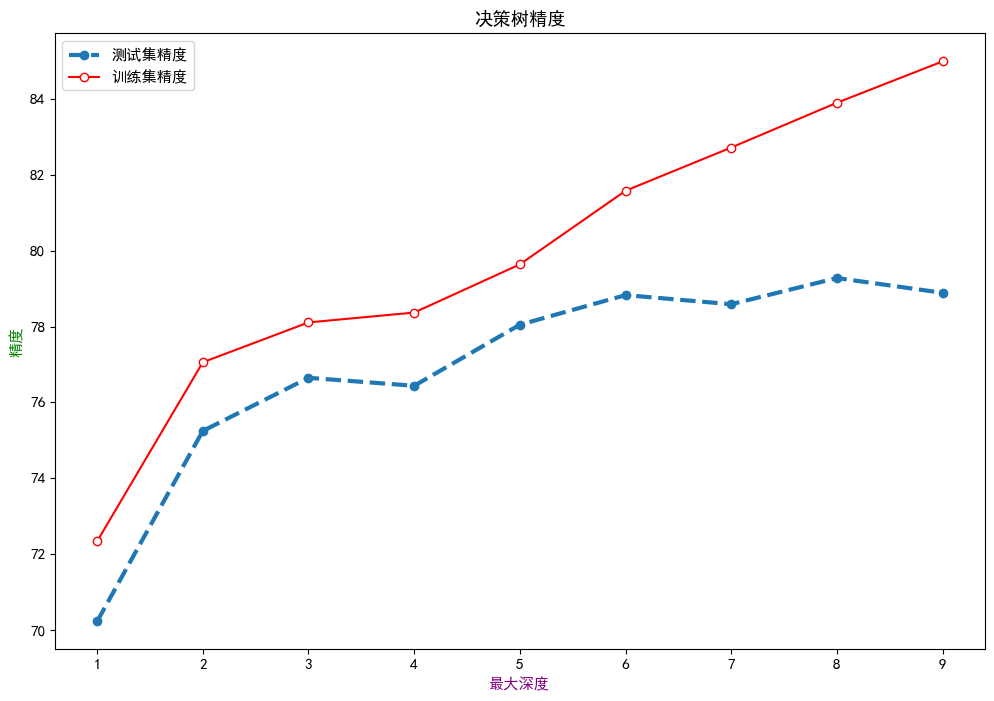

In [11]:
# 数据集分割 deposite作为结果其余作为输入分割
bank_with_dummies_drop_deposite = bank_with_dummies.drop('deposit', axis=1)  # x输入集
label = bank_with_dummies.deposit  # y输出集

data_train, data_test, label_train, label_test = train_test_split(
    bank_with_dummies_drop_deposite, label, test_size=0.3, random_state=50
)

# 决策树
k_plot = []  # 存储每次不同深度下的测试集精度
t_plot = []  # 存储每次不同深度下的训练集精度
for k in range(1, 10, 1):  # 深度1~9
    # 创建决策树分类器，设置最大深度为k，固定随机种子为101（保证结果可复现）
    dt = DecisionTreeClassifier(max_depth=k, random_state=101)
    dt.fit(data_train, label_train)  # 拟合
    predict = dt.predict(data_test)  # 预测
    # accuracy:精度，精准的准确的  score计算决策树的平均准确率 * 100转化为百分比形式, round(85.565564, 2)保留两位小数
    accuracy_test = round(dt.score(data_test, label_test) * 100, 2)  # 计算测试集精度保留两位小数
    accuracy_train = round(dt.score(data_train, label_train) * 100, 2)  # 计算训练集精度保留两位小数
    print(k)  # 深度
    print('训练精度', accuracy_train)
    print('测试精度', accuracy_test)
    k_plot.append(accuracy_test)  # 记录精度画图
    t_plot.append(accuracy_train)

fig, axes = plt.subplots(1, 1, figsize=(12, 8))
# k 值 1~10 x 轴也是 1~10
axes.set_xticks(range(1, 10, 1))
plt.title('决策树精度')
plt.xlabel('最大深度', c='purple')
plt.ylabel('精度', c='g')
k = range(1, 10, 1)
plt.plot(k, k_plot, linewidth=3.0, linestyle='--', marker='o')
plt.plot(k, t_plot, 'r', marker='o', markerfacecolor='w')
plt.legend(['测试集精度', '训练集精度'])
plt.show()

精度值:
0.7805315019408778
Area Under Curve:
0.8621944547743006


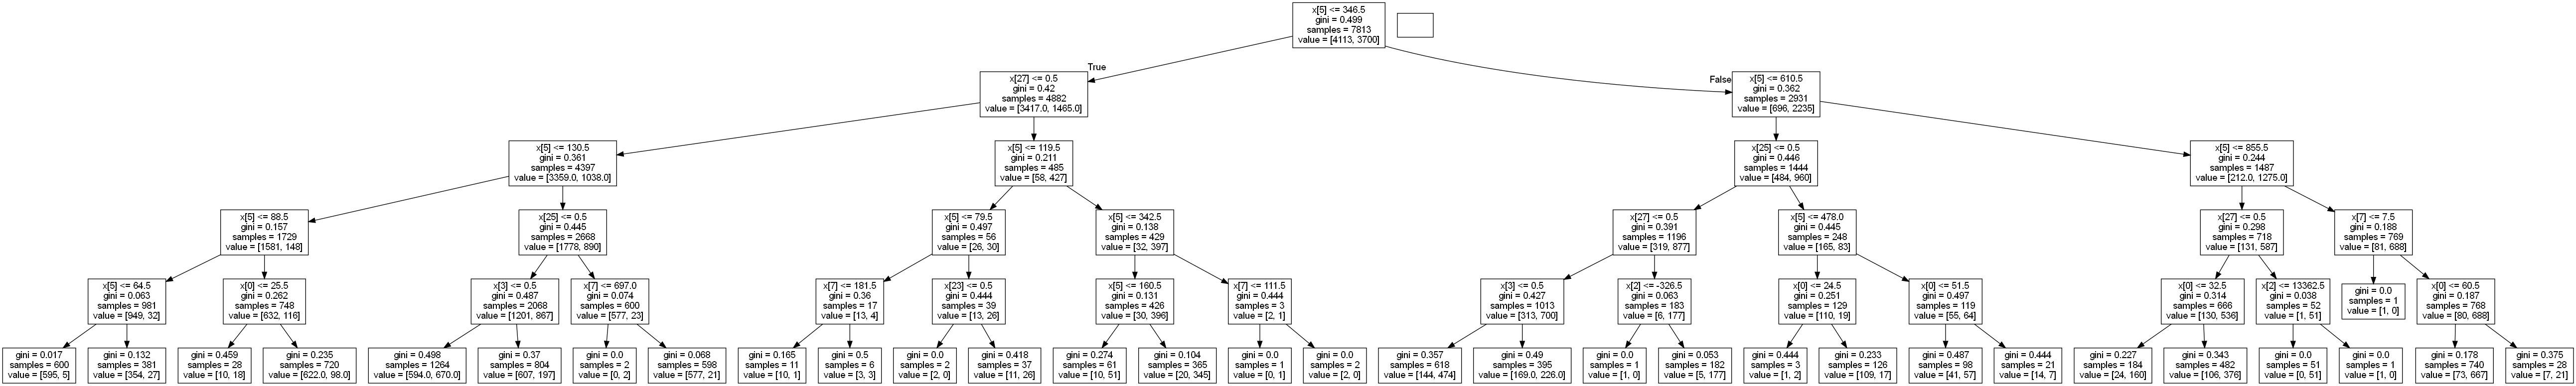

In [12]:
# 当 k = 7 时计算精度
# 重新训练模型
df = DecisionTreeClassifier(max_depth=5, random_state=101)
df.fit(data_train, label_train)
preds = df.predict(data_test)  # 对测试集进行预测
# 
print('精度值:\n{}'.format(metrics.accuracy_score(label_test, preds)))

# 测试集上使用predict_proba预测
probs = df.predict_proba(data_test)[:, 1]
# 计算AUC metric
print('Area Under Curve:\n{}'.format(metrics.roc_auc_score(label_test, probs)))

# 决策树结构图
features = bank_with_dummies_drop_deposite.columns.tolist()
tree.export_graphviz(
    df, out_file='tree_depth.dot', feature_names=features
)

# 另存为pdf
dot_data = tree.export_graphviz(df, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf('tree_depth.pdf')

# 可视化数据
Image(graph.create_png())

## 具体代码实现流程详细实现图

In [13]:
bank_with_dummies

,age,default,balance,housing,loan,duration,campaign,pdays,previous,deposit,...,education_primary,education_secondary,education_tertiary,education_unknown,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_success,poutcome_unknown
0,18,0,108,0,0,167,1,1000,0,1,...,0,0,0,1,1,0,0,0,0,1
1,18,0,608,0,0,267,1,1000,0,1,...,1,0,0,0,1,0,0,0,0,1
2,18,0,108,0,0,169,1,1000,0,1,...,0,0,0,1,1,0,0,0,0,1
3,18,0,608,0,0,210,1,93,1,1,...,1,0,0,0,1,0,0,0,1,0
4,18,0,108,0,0,92,1,183,1,1,...,0,0,0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,92,0,775,0,0,313,3,1000,0,1,...,0,0,0,1,1,0,0,0,0,1
11158,92,0,775,0,0,164,4,96,3,1,...,0,0,0,1,1,0,0,0,1,0
11159,93,0,775,0,0,860,2,177,7,1,...,0,0,0,1,1,0,0,0,1,0
11160,93,0,775,0,0,476,2,13,9,1,...,0,0,0,1,1,0,0,0,1,0


In [14]:
bank_with_dummies_drop_deposite = bank_with_dummies.drop('deposit', axis=1)
label = bank_with_dummies.deposit
label

0        1
1        1
2        1
3        1
4        1
        ..
11157    1
11158    1
11159    1
11160    1
11161    1
Name: deposit, Length: 11162, dtype: int32

In [15]:
data_train, data_test, label_train, label_test = train_test_split(
    bank_with_dummies_drop_deposite, label, test_size=0.3, random_state=50
)
print(data_train.shape[0])
print(data_test.shape[0])
print(label_train.shape[0])
print(label_test.shape[0])

7813
3349
7813
3349


In [16]:
# 决策树
k_plot = []  # 存储每次不同深度下的测试集精度
t_plot = []  # 存储每次不同深度下的训练集精度
for k in range(1, 10, 1):  # 深度1~9
    # 创建决策树分类器，设置最大深度为k，固定随机种子为101（保证结果可复现）
    dt = DecisionTreeClassifier(max_depth=k, random_state=101)
    dt.fit(data_train, label_train)  # 拟合
    predict = dt.predict(data_test)  # 预测
    accuracy_test = round(dt.score(data_test, label_test) * 100, 2)  # 计算测试集精度保留两位小数
    accuracy_train = round(dt.score(data_train, label_train) * 100, 2)  # 计算训练集精度保留两位小数
    print(k)  # 深度
    print('训练精度', accuracy_train)
    print('测试精度', accuracy_test)
    k_plot.append(accuracy_test)  # 记录精度画图
    t_plot.append(accuracy_train)

1
训练精度 72.34
测试精度 70.23
2
训练精度 77.06
测试精度 75.25
3
训练精度 78.11
测试精度 76.65
4
训练精度 78.37
测试精度 76.44
5
训练精度 79.64
测试精度 78.05
6
训练精度 81.58
测试精度 78.83
7
训练精度 82.72
测试精度 78.59
8
训练精度 83.9
测试精度 79.28
9
训练精度 84.99
测试精度 78.89


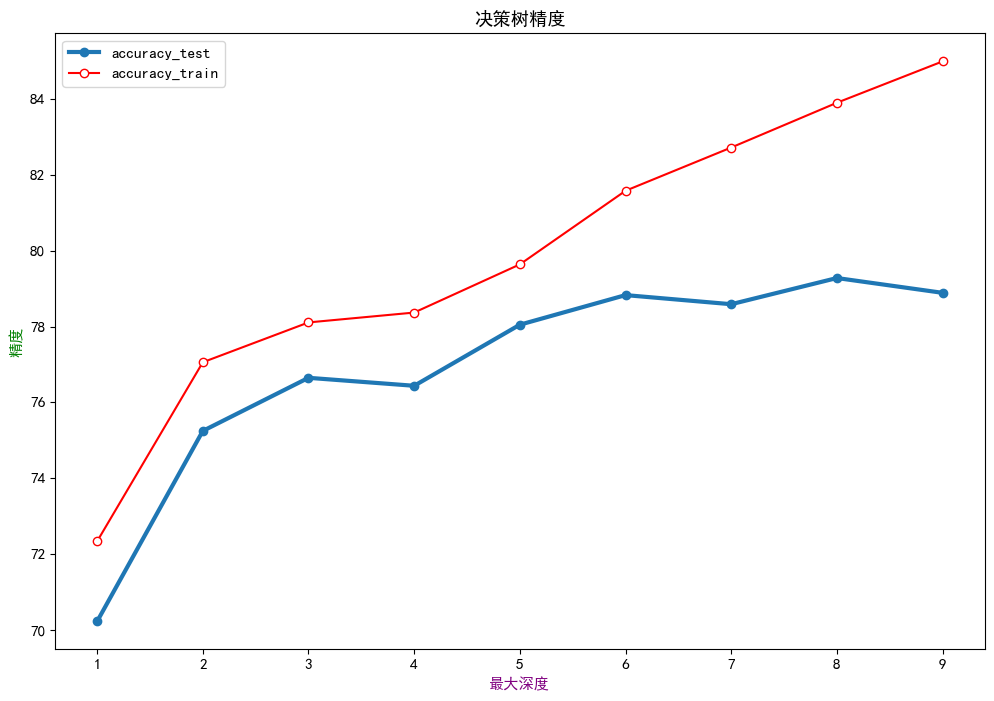

In [17]:
fig, axes = plt.subplots(1, 1, figsize=(12, 8))
axes.set_xticks(range(1, 10, 1))
plt.title('决策树精度')
plt.xlabel('最大深度', c='purple')
plt.ylabel('精度', c='g')
k = range(1, 10, 1)
plt.plot(k, k_plot, linewidth=3.0, linestyle='-', marker='o')
plt.plot(k, t_plot, 'r', marker='o', markerfacecolor='w')
plt.legend(['accuracy_test', 'accuracy_train'])
plt.show()